In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2024-05-19 12:01:34.454628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 12:01:35.202489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Recriando o script

In [2]:
# Importações necessárias para o código
from __future__ import print_function
import argparse
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
import tensorflow as tf


Aqui, explicaremos o objetivo do notebook: treinar um classificador de regressão logística para distinguir dígitos MNIST 3 e 8, com capacidade de remoção de pontos de dados do treinamento.

### Configuração dos argumentos e do dispositivo

In [3]:
args = argparse.Namespace(
    data_dir='',  # Já temos na variável x_train_selected
    result_dir='result',
    extractor='none',
    dataset='MNIST',
    lam=1e-3,
    std=10,
    num_removes=1000,
    train_splits=1,
    subsample_ratio=1.0,
    num_steps=100,
    train_mode='binary',
    verbose=True
)

# Configuração do dispositivo de treinamento (CUDA se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
# Definindo a semente
tf.random.set_seed(42)
np.random.seed(42)

# Carregar os dados do MNIST
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Selecionar apenas os exemplos rotulados como 3 e 8
train_mask = np.logical_or(y_train == 3, y_train == 8)
test_mask = np.logical_or(y_test == 3, y_test == 8)

x_train_selected = x_train[train_mask]
y_train_selected = y_train[train_mask]
x_test_selected = x_test[test_mask]
y_test_selected = y_test[test_mask]

# Normalizar os valores dos pixels para o intervalo [0, 1]
x_train_selected = x_train_selected / 255.0
x_test_selected = x_test_selected / 255.0

# Visualizar o formato dos dados selecionados
print("Formato dos dados de treinamento selecionados:", x_train_selected.shape)
print("Formato dos dados de teste selecionados:", x_test_selected.shape)

Formato dos dados de treinamento selecionados: (11982, 28, 28)
Formato dos dados de teste selecionados: (1984, 28, 28)


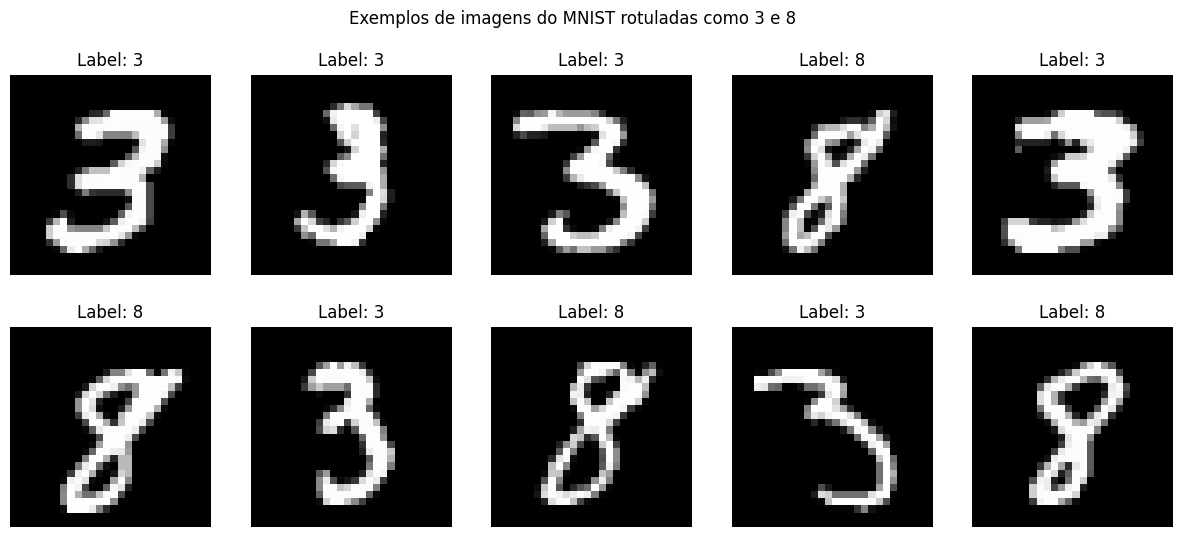

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Exemplos de imagens do MNIST rotuladas como 3 e 8")
for i in range(5):
    axs[0, i].imshow(x_train_selected[i], cmap="gray")
    axs[0, i].set_title("Label: " + str(y_train_selected[i]))
    axs[0, i].axis("off")

    axs[1, i].imshow(x_train_selected[i + 12], cmap="gray")
    axs[1, i].set_title("Label: " + str(y_train_selected[i + 12]))
    axs[1, i].axis("off")

plt.show()


## Preparandos os dados

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convertendo os dados de NumPy arrays para tensores PyTorch
x_train_tensor = torch.tensor(x_train_selected, dtype=torch.float32).reshape(-1, 28*28)  # Achatamento das imagens
x_test_tensor = torch.tensor(x_test_selected, dtype=torch.float32).reshape(-1, 28*28)    # Achatamento das imagens

# Transformando os rótulos para -1 e 1, que são necessários para a função de perda de regressão logística
y_train_tensor = torch.tensor(np.where(y_train_selected == 3, 1, -1), dtype=torch.float32)
y_test_tensor = torch.tensor(np.where(y_test_selected == 3, 1, -1), dtype=torch.float32)

# Criando conjuntos de dados e carregadores para treinamento e teste
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Definindo o carregador de dados (data loader)
batch_size = 64  # Definir conforme necessário
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificação dos tensores
print("Formato dos tensores de treinamento:", x_train_tensor.shape, y_train_tensor.shape)
print("Formato dos tensores de teste:", x_test_tensor.shape, y_test_tensor.shape)


Formato dos tensores de treinamento: torch.Size([11982, 784]) torch.Size([11982])
Formato dos tensores de teste: torch.Size([1984, 784]) torch.Size([1984])


## Funções de auxílio para o treinamento

In [7]:
# Função para calcular a perda de regressão logística
def lr_loss(w, X, y, lam):
    """
    Calcula a perda de regressão logística com regularização L2.
    
    Parâmetros:
        w (Tensor): Pesos do modelo.
        X (Tensor): Dados de entrada.
        y (Tensor): Rótulos de saída.
        lam (float): Fator de regularização L2.
        
    Retorna:
        Tensor: Valor da perda.
    """
    return -F.logsigmoid(y * X.mv(w)).mean() + lam * w.pow(2).sum() / 2

# Função para avaliar a precisão do modelo
def lr_eval(w, X, y):
    """
    Avalia a precisão do modelo.
    
    Parâmetros:
        w (Tensor): Pesos do modelo.
        X (Tensor): Dados de entrada.
        y (Tensor): Rótulos de saída.
    
    Retorna:
        float: Acurácia do modelo.
    """
    return X.mv(w).sign().eq(y).float().mean()

# Função para calcular o gradiente da perda de regressão logística
def lr_grad(w, X, y, lam):
    """
    Calcula o gradiente da perda de regressão logística.
    
    Parâmetros:
        w (Tensor): Pesos do modelo.
        X (Tensor): Dados de entrada.
        y (Tensor): Rótulos de saída.
        lam (float): Fator de regularização L2.
        
    Retorna:
        Tensor: Gradiente da perda.
    """
    z = torch.sigmoid(y * X.mv(w))
    return X.t().mv((z - 1) * y) + lam * X.size(0) * w

# Função para otimizar os pesos do modelo usando L-BFGS
def lr_optimize(X, y, lam, b=None, num_steps=100, tol=1e-10, verbose=False):
    """
    Otimiza os pesos do modelo usando o otimizador L-BFGS.
    
    Parâmetros:
        X (Tensor): Dados de entrada.
        y (Tensor): Rótulos de saída.
        lam (float): Fator de regularização L2.
        b (Tensor): Vetor de perturbação objetiva, opcional.
        num_steps (int): Número máximo de passos de otimização.
        tol (float): Tolerância para o critério de parada.
        verbose (bool): Se True, imprime informações de cada iteração.
    
    Retorna:
        Tensor: Pesos otimizados do modelo.
    """
    w = torch.autograd.Variable(torch.zeros(X.size(1)).float().to(device), requires_grad=True)
    optimizer = optim.LBFGS([w], tolerance_grad=tol, tolerance_change=1e-20)
    
    def closure():
        optimizer.zero_grad()
        loss = lr_loss(w, X, y, lam) + (b.dot(w) / X.size(0) if b is not None else 0)
        loss.backward()
        return loss
    
    for i in range(num_steps):
        optimizer.step(closure)
        if verbose:
            with torch.no_grad():
                print(f'Iteration {i + 1}: loss = {closure().item():.6f}')
                
    return w.data


## Treinamento do Modelo

In [8]:
# Inicializa os pesos do modelo com valores aleatórios
w = torch.randn(x_train_tensor.size(1), device=device, dtype=torch.float32) * 1e-3
w.requires_grad_(True)

# Define o fator de regularização L2
lambda_reg = args.lam

# Função de fechamento modificada para assegurar que os gradientes são calculados
def closure():
    optimizer.zero_grad()
    loss = lr_loss(w, x_train_tensor.to(device), y_train_tensor.to(device), lambda_reg)
    loss.backward()
    return loss

# Otimiza os pesos do modelo usando L-BFGS
optimizer = optim.LBFGS([w], tolerance_grad=1e-10, tolerance_change=1e-20)

for i in range(args.num_steps):
    optimizer.step(closure)
    if args.verbose:
        print(f'Iteration {i + 1}: loss = {closure().item():.6f}')

# Avalia o modelo no conjunto de teste
accuracy = lr_eval(w, x_test_tensor.to(device), y_test_tensor.to(device))
print("Acurácia no conjunto de teste: {:.4f}".format(accuracy))


Iteration 1: loss = 0.107124
Iteration 2: loss = 0.106479
Iteration 3: loss = 0.106479
Iteration 4: loss = 0.106479
Iteration 5: loss = 0.106479
Iteration 6: loss = 0.106479
Iteration 7: loss = 0.106479
Iteration 8: loss = 0.106479
Iteration 9: loss = 0.106479
Iteration 10: loss = 0.106479
Iteration 11: loss = 0.106479
Iteration 12: loss = 0.106479
Iteration 13: loss = 0.106479
Iteration 14: loss = 0.106479
Iteration 15: loss = 0.106479
Iteration 16: loss = 0.106479
Iteration 17: loss = 0.106479
Iteration 18: loss = 0.106479
Iteration 19: loss = 0.106479
Iteration 20: loss = 0.106479
Iteration 21: loss = 0.106479
Iteration 22: loss = 0.106479
Iteration 23: loss = 0.106479
Iteration 24: loss = 0.106479
Iteration 25: loss = 0.106479
Iteration 26: loss = 0.106479
Iteration 27: loss = 0.106479
Iteration 28: loss = 0.106479
Iteration 29: loss = 0.106479
Iteration 30: loss = 0.106479
Iteration 31: loss = 0.106479
Iteration 32: loss = 0.106479
Iteration 33: loss = 0.106479
Iteration 34: loss 

### Visualização dos pesos do modelo

Formato dos pesos: torch.Size([784])


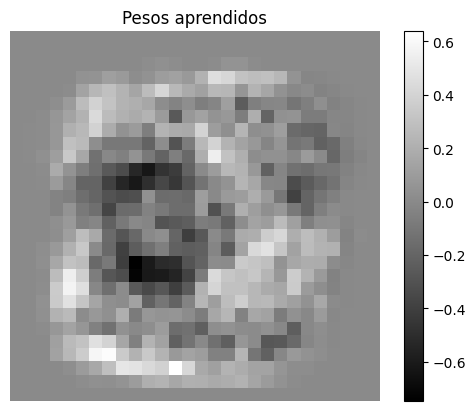

In [9]:
# vamos visualizar os pesos aprendidos
print("Formato dos pesos:", w.shape)

weights = w.detach().cpu().numpy().reshape(28, 28)
plt.imshow(weights, cmap="gray")
plt.title("Pesos aprendidos")
plt.axis("off")
plt.colorbar()
plt.show()

### Implementando a Remoção de Dados

In [10]:
def remove_data_point(X_train, y_train, w, lam, idx_to_remove):
    """
    Atualiza os pesos do modelo para remover a influência de pontos de dados específicos.
    
    Parâmetros:
        X_train (Tensor): Dados de treinamento.
        y_train (Tensor): Rótulos de treinamento.
        w (Tensor): Pesos atuais do modelo.
        lam (float): Coeficiente de regularização L2.
        idx_to_remove (int): Índice do ponto de dado a ser removido.
    
    Retorna:
        Tensor: Pesos atualizados após a remoção.
    """
    # Calcula o gradiente para o ponto de dado específico
    with torch.no_grad():
        # Calcula o gradiente para o ponto de dado específico
        grad = lr_grad(w, X_train[idx_to_remove:idx_to_remove+1], y_train[idx_to_remove:idx_to_remove+1], lam)
        
        # Estima o inverso da matriz Hessiana
        hessian_inv = torch.inverse(X_train.t().mm(X_train) + lam * torch.eye(X_train.size(1)).to(X_train.device))
        
        # Atualiza os pesos de forma out-of-place
        w_new = w - hessian_inv.mm(grad.unsqueeze(1)).squeeze()


    return w_new


Vamos remover os 1000 primeiros pontos de dados.

In [11]:
for idx in range(3000):
    w = remove_data_point(x_train_tensor.to(device), y_train_tensor.to(device), w, args.lam, 1)


Formato dos pesos: torch.Size([784])


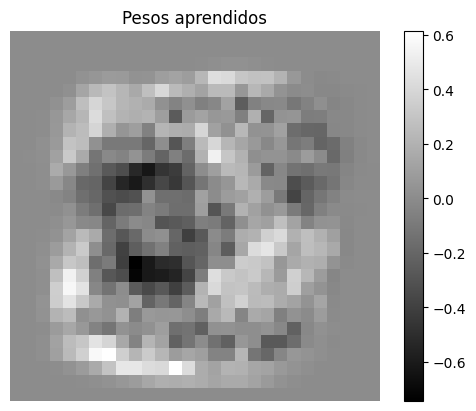

In [13]:
# vamos visualizar os pesos aprendidos
print("Formato dos pesos:", w.shape)

weights = w.detach().cpu().numpy().reshape(28, 28)
plt.imshow(weights, cmap="gray")
plt.title("Pesos aprendidos")
plt.axis("off")
plt.colorbar()
plt.show()